# Fine-tuning and deploying Small Language Models using Amazon SageMaker

---
In this demo notebook, we demonstrate how to use the SageMaker Python SDK to fine-tuning and deploy Small Language models for text generation. For fine-tuning, we include two types of fine-tuning: instruction fine-tuning and domain adaption fine-tuning. 

Our goal is to prove that Fine-tuning a Small Language Model is more cost-effective and a better strategy than larger models.

---

We begin by installing and upgrading necessary packages. Restart the kernel after executing the cell below for the first time.

In [ ]:
%pip install sagemaker==2.229 datasets huggingface_hub --upgrade --quiet --no-warn-conflicts

In [ ]:
import sagemaker
import huggingface_hub

**Baseline SageMaker setup**

In [ ]:
role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
bucket = sess.default_bucket()  # bucket to house artifacts
region = sess._region_name  # region name of the current SageMaker Studio environment

print(f"SageMaker version: {sagemaker.__version__}")

## 1. Deploy model on Amazon SageMaker Endpoint

### 1.1 Deploying Llama 3.1-8B-Instruct through Jumpstart

We'll start by deploying our Llama-3.1-8B-Instruct model from JumpStart and testing the endpoint

#### Deploying model from SageMaker JumpStart (UI experience)

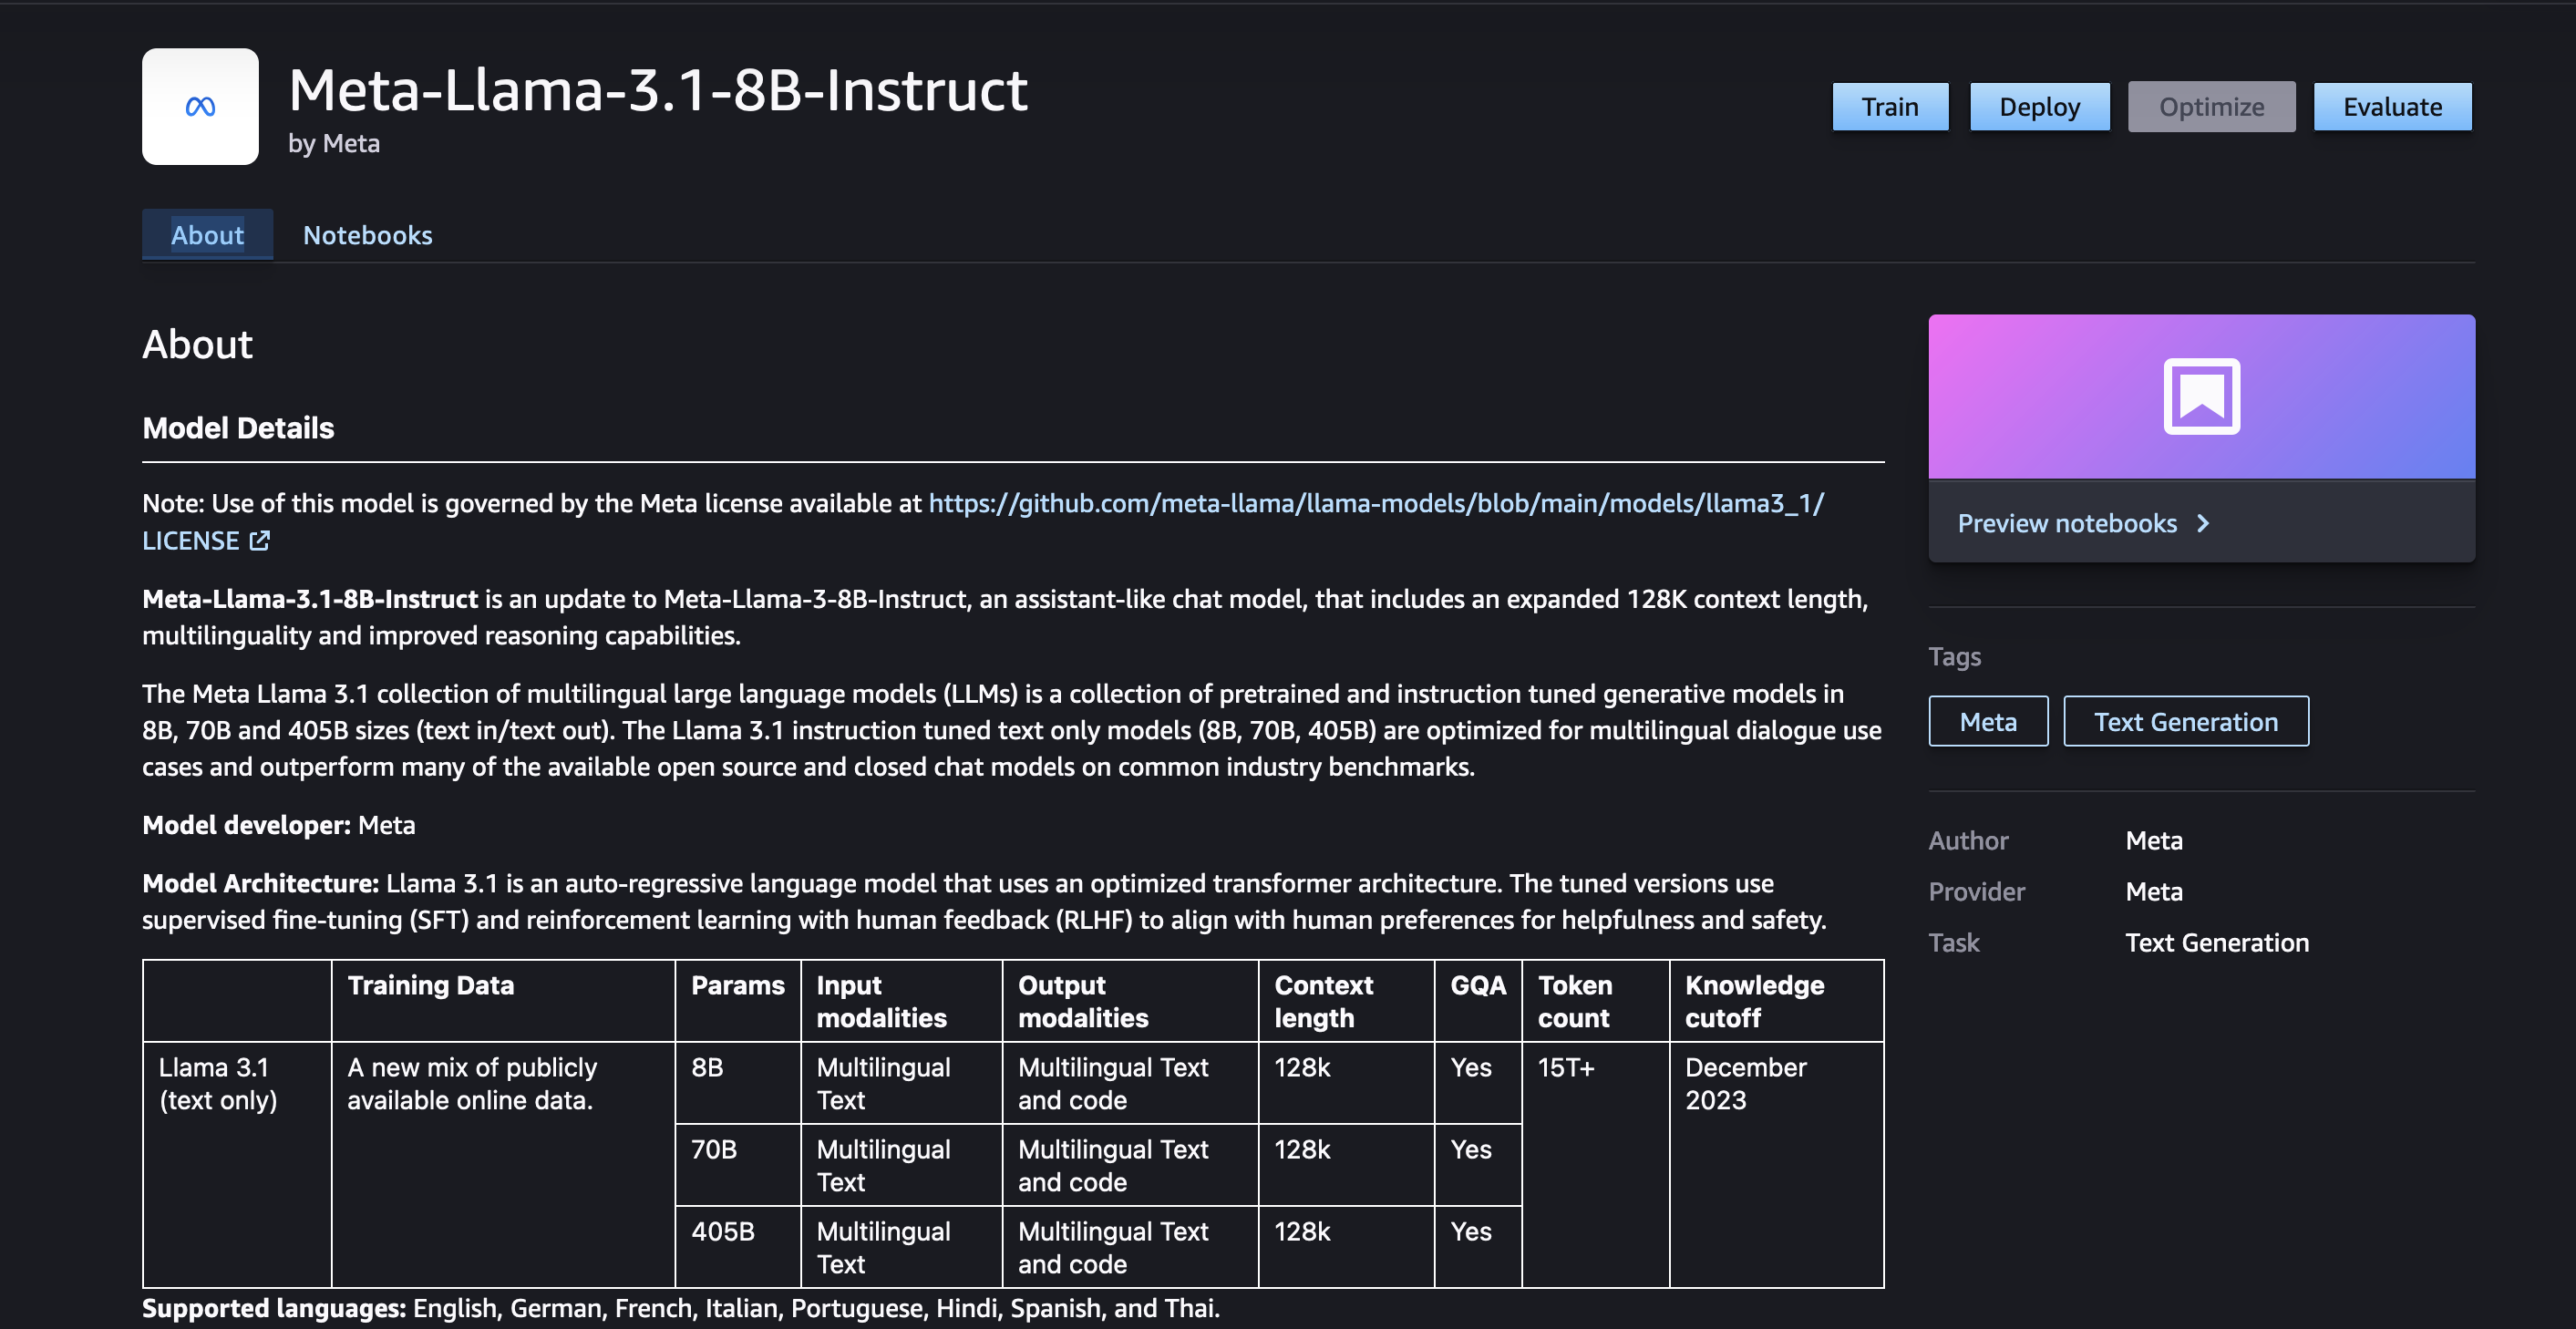

#### Deploying model from SageMaker JumpStart (SageMaker PySDK)

In [ ]:
from sagemaker.jumpstart.model import JumpStartModel

In [ ]:
model_id, model_version = "meta-textgeneration-llama-3-1-8b-instruct", "2.1.0"

pretrained_model = JumpStartModel(model_id=model_id, model_version=model_version)
#
# Please change the following line to have accept_eula = True
pretrained_predictor = pretrained_model.deploy(accept_eula=True, instance_type="ml.g5.2xlarge")

In [ ]:
payload = {
    "inputs": "What is Amazon SageMaker?",
    "parameters": {
        "max_new_tokens": 128,
        "top_p": 0.9,
        "temperature": 0.6,
        "return_full_text": False,
    },
}
res = pretrained_predictor.predict(payload)
print("\n---\n",res["generated_text"], "\n---\n")

In [ ]:
pretrained_predictor.delete_model()
pretrained_predictor.delete_endpoint()

### 1.2 Deploying a model from Amazon S3 bucket or HuggingFace model hub

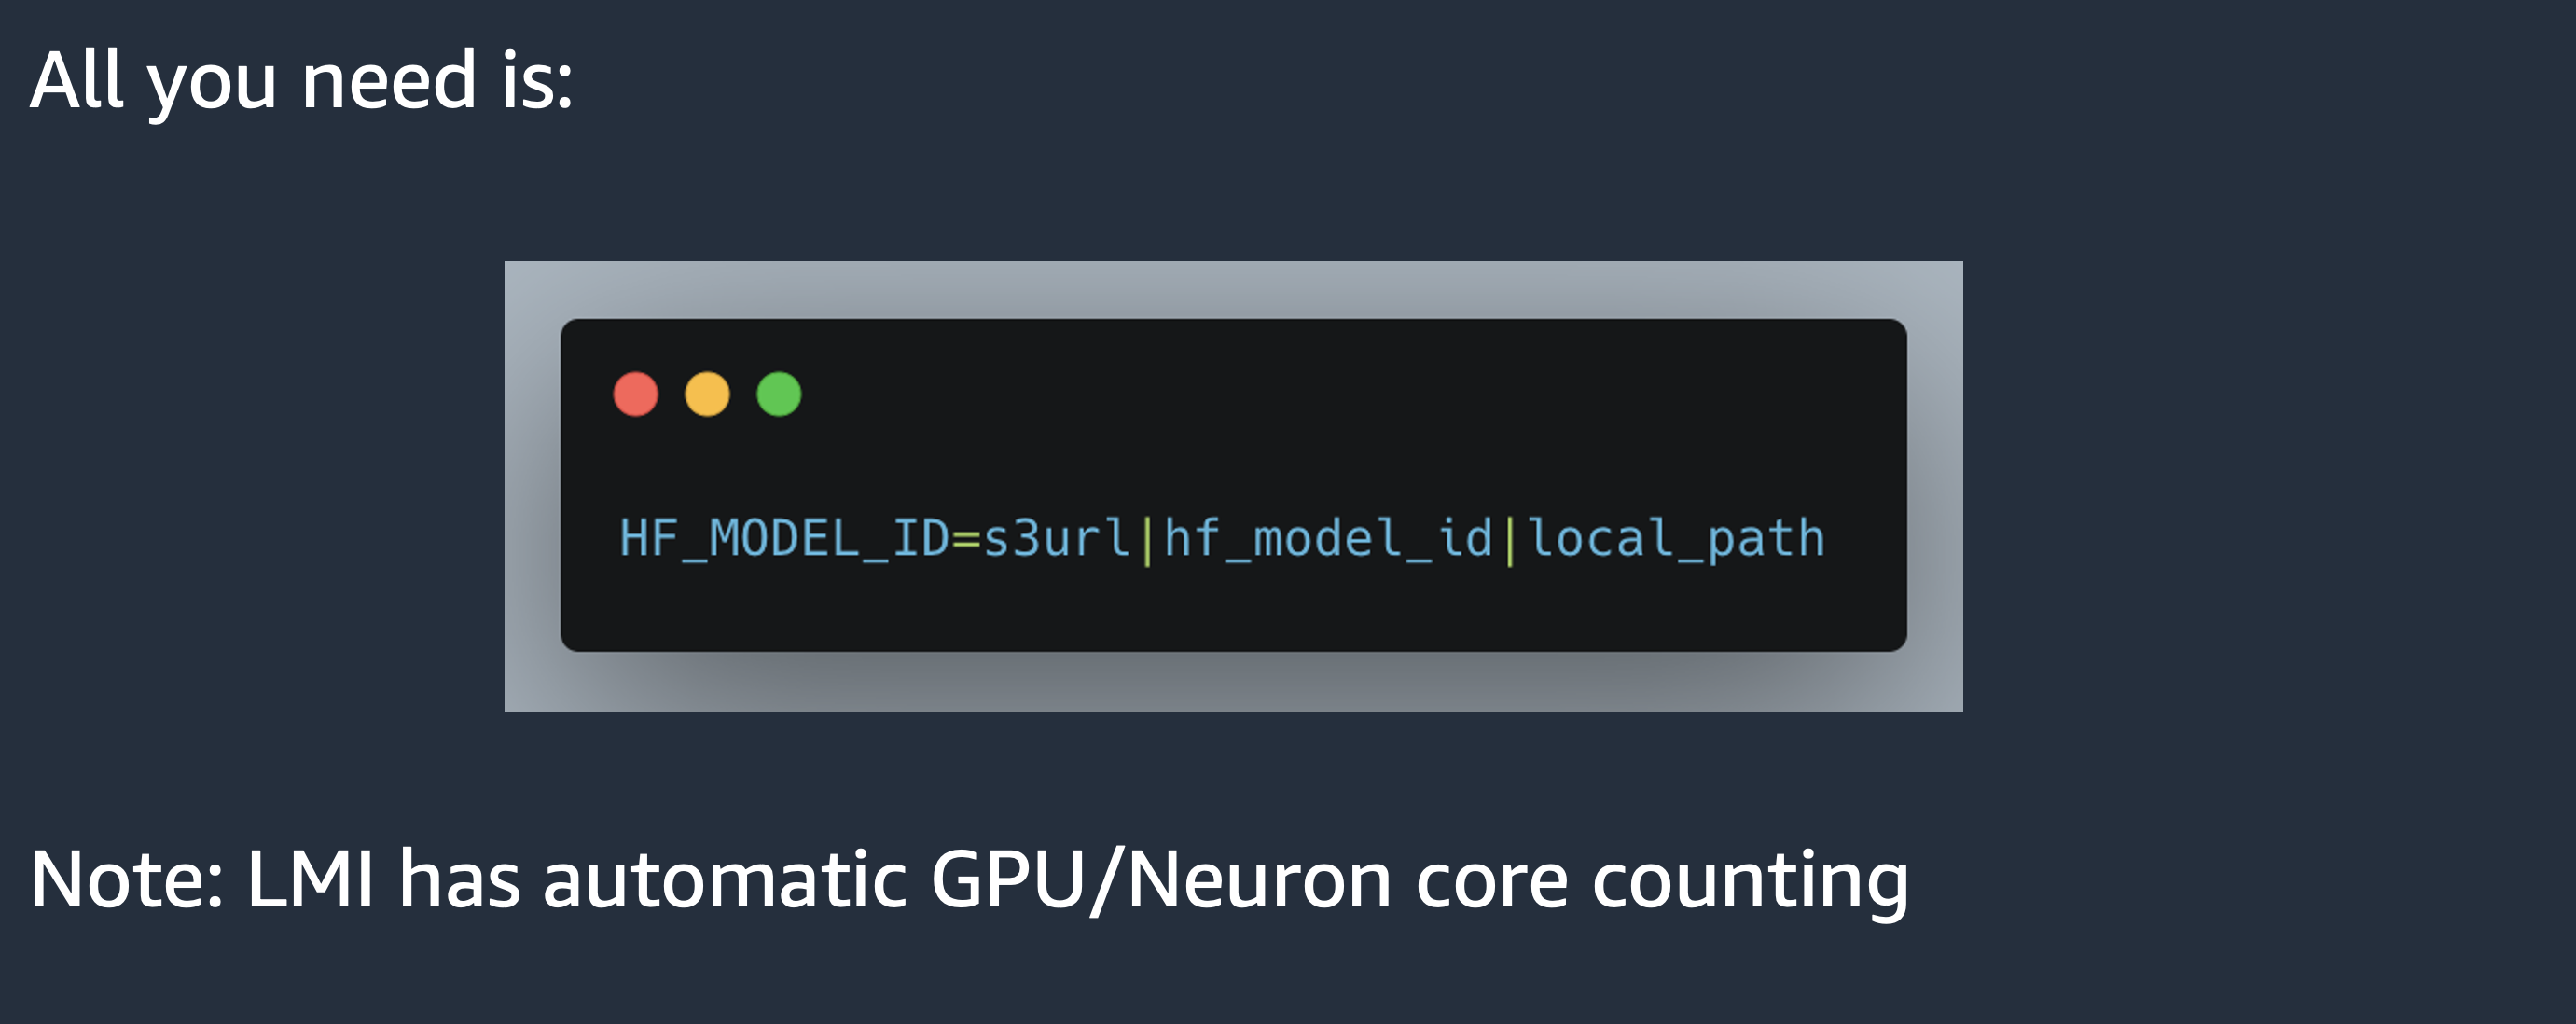

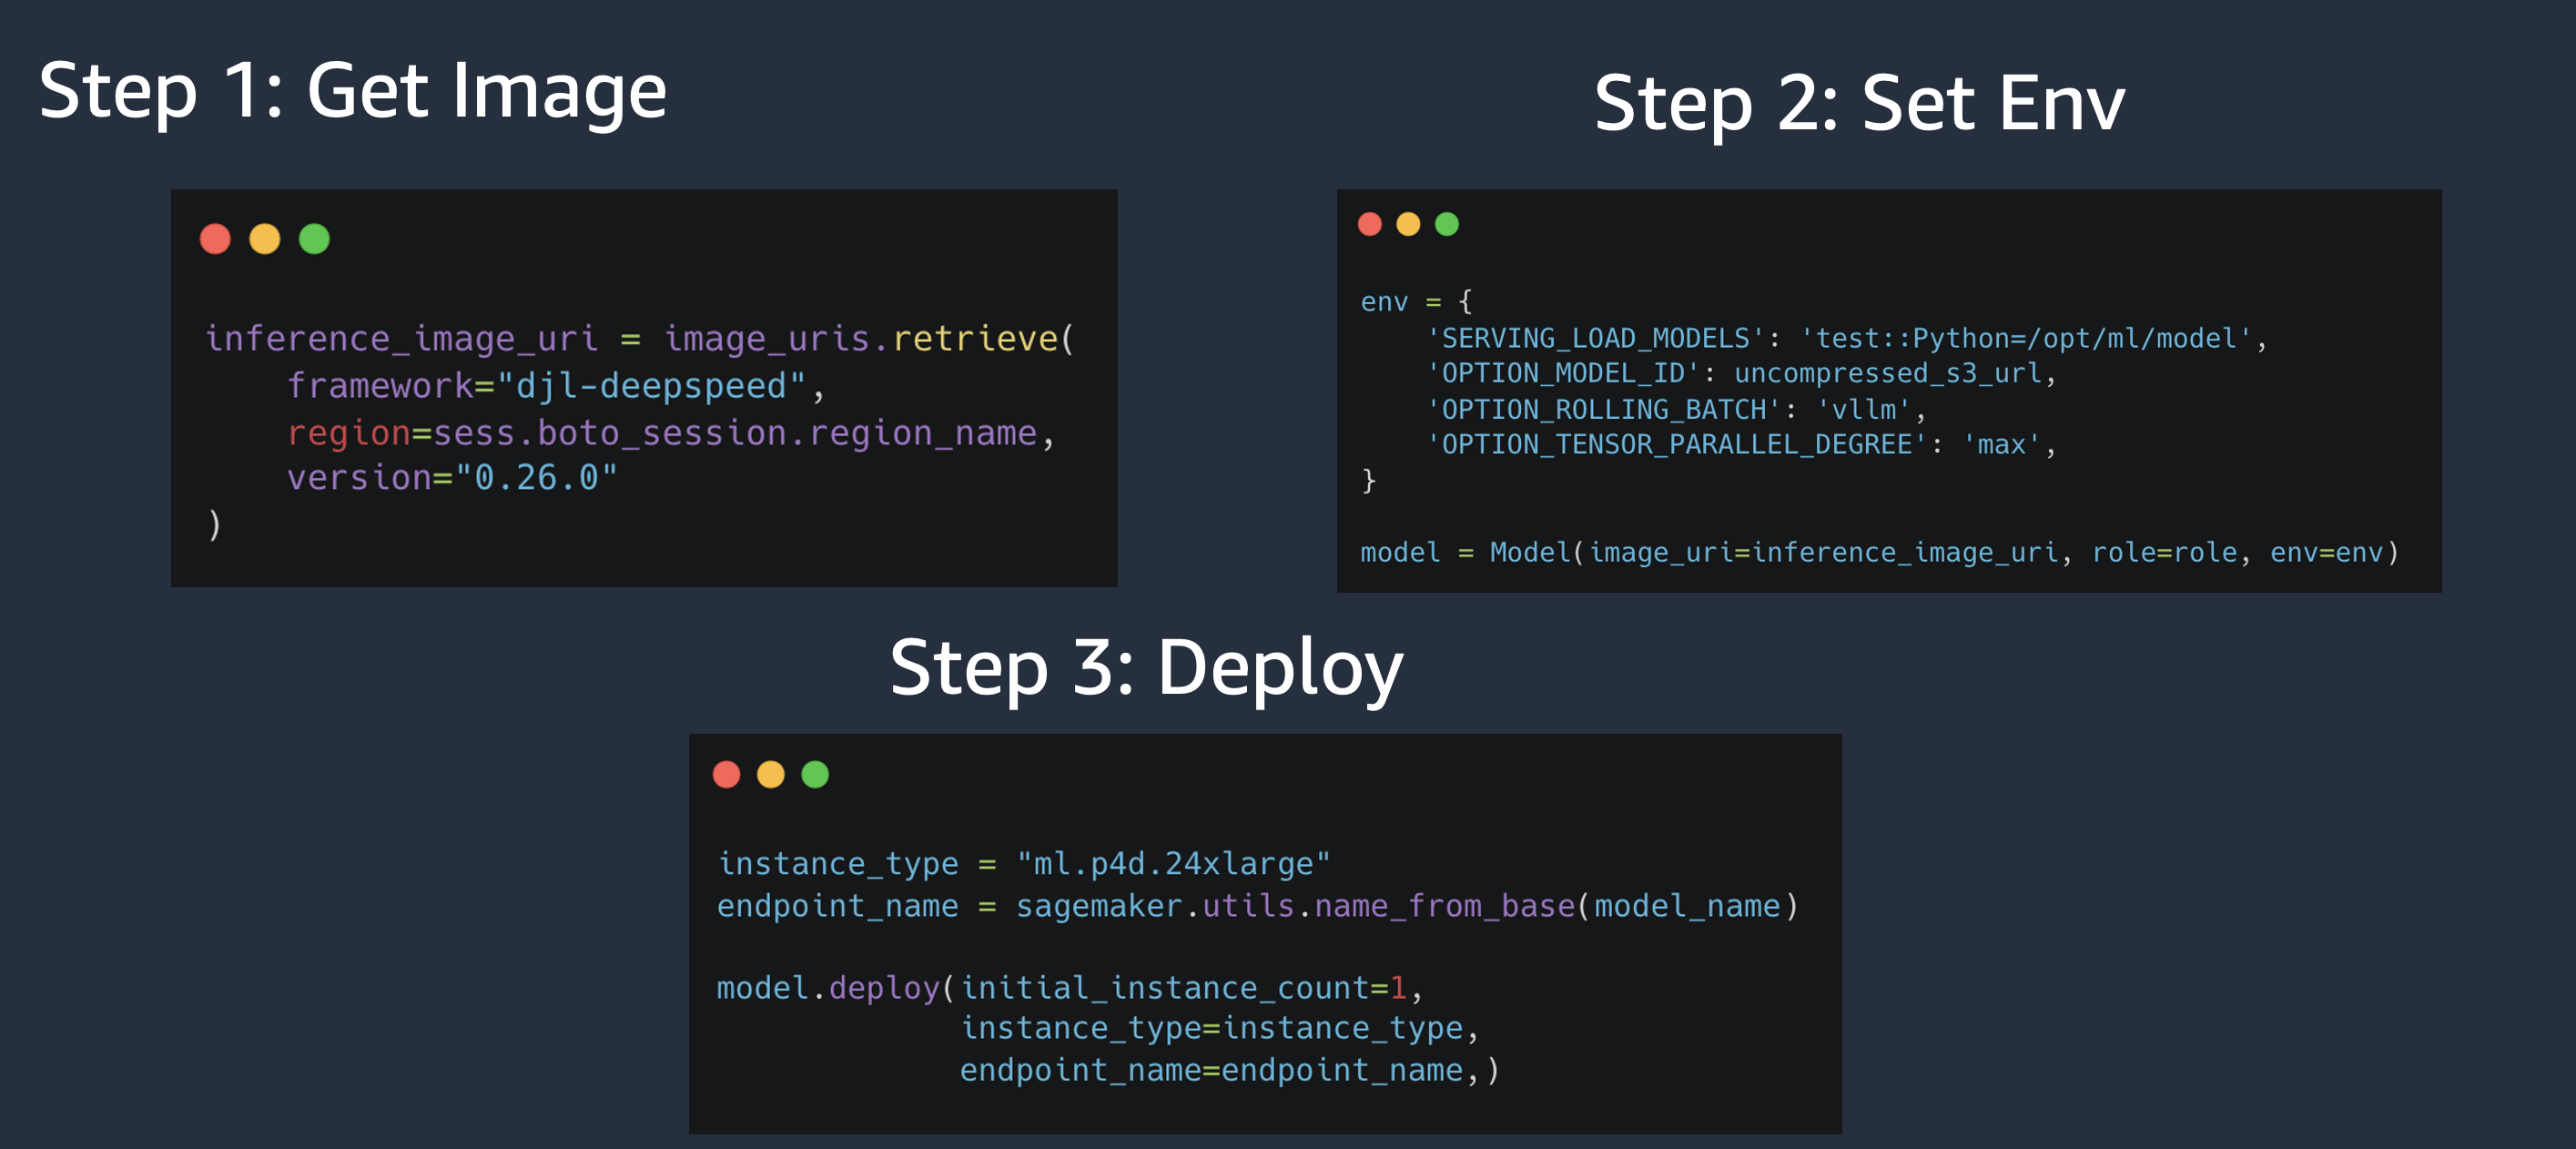

**Large Model Inference (LMI) Containers**

In this example you will deploy your model using SageMaker's Large Model Inference (LMI) Containers.

LMI containers are a set of high-performance Docker Containers purpose built for large language model (LLM) inference. With these containers, you can leverage high performance open-source inference libraries like vLLM, TensorRT-LLM, Transformers NeuronX to deploy LLMs on AWS SageMaker Endpoints. These containers bundle together a model server with open-source inference libraries to deliver an all-in-one LLM serving solution.

The LMI container supports a variety of different backends, outlined in the table below. 

| Backend | SageMakerDLC | Example URI |
| --- | --- | --- |
|vLLM|djl-lmi|763104351884.dkr.ecr.us-east-1.amazonaws.com/djl-inference:0.29.0-lmi11.0.0-cu124
|lmi-dist|djl-lmi|763104351884.dkr.ecr.us-east-1.amazonaws.com/djl-inference:0.29.0-lmi11.0.0-cu124
|hf-accelerate|djl-lmi|763104351884.dkr.ecr.us-east-1.amazonaws.com/djl-inference:0.29.0-lmi11.0.0-cu124
|tensorrt-llm|djl-tensorrtllm|763104351884.dkr.ecr.us-east-1.amazonaws.com/djl-inference:0.29.0-tensorrtllm0.11.0-cu124
|transformers-neuronx|djl-neuronx|763104351884.dkr.ecr.us-east-1.amazonaws.com/djl-inference:0.29.0-neuronx-sdk2.19.1

In [ ]:
LMI_VERSION = "0.29.0"
LMI_FRAMEWORK = 'djl-lmi'

lmidist_image = sagemaker.image_uris.retrieve(framework=LMI_FRAMEWORK, region=region, version=LMI_VERSION)

print(f"Inference Image: {lmidist_image}")

#### Model License Information
Meta Llama-3.1 model a gated model. To use this model you have to agree to the license agreement and request access before the model can be used in this notebook.

---
You will need your ***own*** HF token in order to deploy gated models from the HuggingFace

If you already have model artificts downloaded to S3 you can use S3 URI in HF_MODEL_ID key

For the purpose of this workshop we will be using Llama-2-7B from SageMaker public S3 bucket

---

In [ ]:
lmidist_config = {
    #"HF_MODEL_ID": "meta-llama/Meta-Llama-3.1-8B-Instruct",
    #"HF_TOKEN": "YOU_SECRET_TOKEN",
    "HF_MODEL_ID": "s3://sagemaker-example-files-prod-us-west-2/models/llama-2/fp16/7B/",
    "OPTION_MAX_MODEL_LEN": "2048",
    "OPTION_GPU_MEMORY_UTILIZATION": "0.8",
}

In [ ]:
model_name = sagemaker.utils.name_from_base("slm-workshop")
endpoint_name = model_name

lmi_model = sagemaker.Model(
    image_uri = lmidist_image,
    env = lmidist_config,
    role = role,
    name = model_name
)

Now that you have a model object ready, you will use use the SageMaker Python SDK to create a SageMaker Managed Endpoint. The SDK eliminates some of the intermediate steps, such as creating an Endpoint Configuration.

***Note: creating a new endpoint can take between 5-8 minutes.***

In [ ]:
lmi_model.deploy(
    initial_instance_count = 1,
    instance_type = "ml.g5.2xlarge",
    container_startup_health_check_timeout = 900,
    endpoint_name = endpoint_name,
)

In [ ]:
llm = sagemaker.Predictor(
    endpoint_name = endpoint_name,
    sagemaker_session = sess,
    serializer = sagemaker.serializers.JSONSerializer(),
    deserializer = sagemaker.deserializers.JSONDeserializer(),
)

payload = {
    "inputs": "What is Amazon SageMaker?",
    "parameters": {
        "max_new_tokens": 128,
        "top_p": 0.9,
        "temperature": 0.6,
    },
}

res = llm.predict(payload)
print("\n---\n",res["generated_text"], "\n---\n")

**Do NOT forget to delete unused endpoint to avoid unnessary charges to your account**

In [ ]:
llm.delete_model()
llm.delete_endpoint()

## 2. Serving LoRA-based Llama 3 adapters with high performance on SageMaker 

This notebook will demonstrate how you can deploy multiple fine-tuned LoRA adapters with a single base model copy on SageMaker using the DJL Serving Large Model Inference DLC. LoRA (Low Rank Adapters) is a powerful technique for fine-tuning large language models. This technique significantly reduces the number of trainable parameters compared to traditional fine-tuning while achieving comparable or superior performance. You can learn more about the LoRA technique in this paper.

A major benefit of LoRA is that the fine-tuned adapters can easily be added to and removed from the base model, which makes switching adapters pretty cheap and viable at runtime. In this notebook we will show how you can deploy a SageMaker endpoint with a single base model and multiple LoRA adapters, and change adapters for different requests.

Since LoRA adapters are much smaller than the size of a base model (can realistically be 100x-1000x smaller), we can deploy an endpoint with a single base model and multiple LoRA adapters using much less hardware than deploying an equivalent number of fully fine-tuned models.

In this notebook, we deploy llama3 as the base model and 3 LoRA adapters fine tuned for a specific language on SageMaker as shown below by leveraging the [SageMaker Large Model Inference Container](https://github.com/aws/deep-learning-containers/blob/master/available_images.md#large-model-inference-containers).

The LMI container offers the out-of-box integration with SageMaker for hosting multiple LoRA adapters with higher performance (low latency and high throughput) using the [vLLM](https://docs.vllm.ai/en/latest/models/lora.html) library that uses [S-LORA](https://github.com/S-LoRA/S-LoRA) and [Punica](https://arxiv.org/pdf/2310.18547.pdf). S-LoRA stores all adapters in the main memory and fetches the adapters used by the currently running queries to the GPU memory. To efficiently use the GPU memory and reduce fragmentation, S-LoRA proposes Unified Paging. Unified Paging uses a unified memory pool to manage dynamic adapter weights with different ranks and KV cache tensors with varying sequence lengths. Additionally, S-LoRA employs a novel tensor parallelism strategy and highly optimized custom CUDA kernels for heterogeneous batching of LoRA computation. Collectively, these features enable S-LoRA to serve thousands of LoRA adapters on a single GPU or across multiple GPUs with a small overhead.

Below diagram shows the Multi LoRA-Adapter serving stack of LMI container on SageMaker

### License agreement
 - View license information https://huggingface.co/meta-llama before using the model.
 - This notebook is a sample notebook and not intended for production use. Please refer to the licence at https://github.com/aws/mit-0. 

In [ ]:
inference_image = sagemaker.image_uris.retrieve(framework="djl-lmi", region=region, version="0.29.0")

### Solution Overview

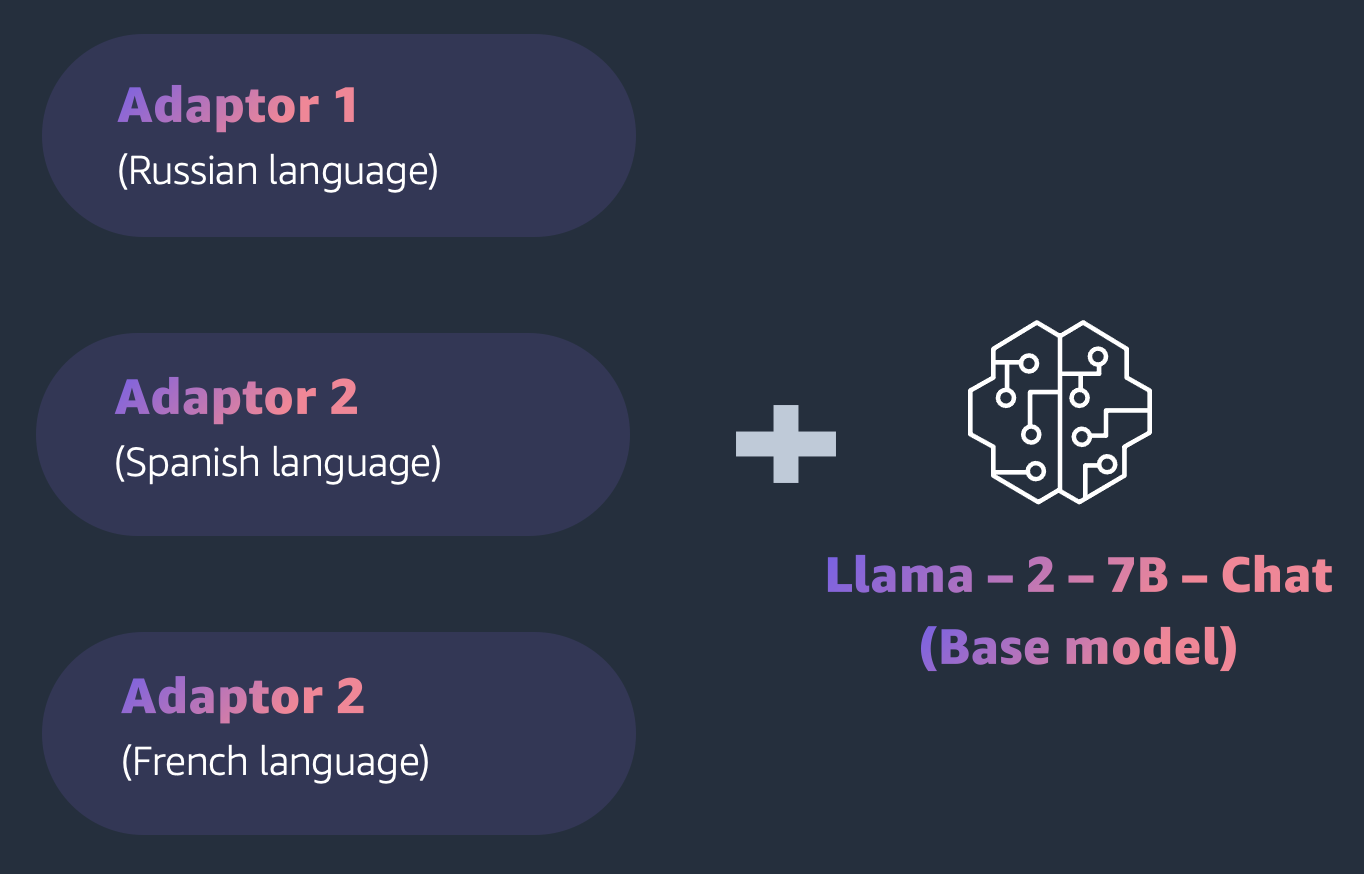

We will be deploying an endpoint with 3 LoRA adapters. These are the models we will be using:

Base Model: Llama-2-7B-Chat-fp16
LoRA Fine Tuned Adapter 1: https://huggingface.co/UnderstandLing/llama-2-7b-chat-ru
LoRA Fine Tuned Adapter 2: https://huggingface.co/UnderstandLing/llama-2-7b-chat-es
LoRA Fine Tuned Adapter 3: https://huggingface.co/UnderstandLing/llama-2-7b-chat-fr

The core structure to cover here is the model directory. We include both the base model and LoRA adapters in the model directory like this:

```
|- model_dir
    |- adapters/
        |--- <adapter_1>/
        |--- <adapter_2>/
        |--- ...
        |--- <adapter_n>/
    |- serving.properties
    |- model.py (optional)

```

It is also possible to have model files located in a separate s3 bucket by specifying that location using an s3 `option.model_id` in the serving.properties. In this case, the adapters directory can be located either alongside the `serving.properties` or alongside the model files in s3.

Each of the adapters in the `adapters` directory contains the LoRA adapter artifacts. Typically there are two files: `adapter_model.bin` and `adapter_config.json` which are the adapter weights and adapter configuration respectively. These are typically obtained from the Peft library via the `PeftModel.save_pretrained()` method.

In [ ]:
!rm -rf lora-multi-adapter
!mkdir -p lora-multi-adapter/adapters

In [ ]:
huggingface_hub.snapshot_download("UnderstandLing/llama-2-7b-chat-ru", local_dir="lora-multi-adapter/adapters/ru")

In [ ]:
huggingface_hub.snapshot_download("UnderstandLing/llama-2-7b-chat-es", local_dir="lora-multi-adapter/adapters/es")

In [ ]:
huggingface_hub.snapshot_download("UnderstandLing/llama-2-7b-chat-fr", local_dir="lora-multi-adapter/adapters/fr")

In [ ]:
# option.model_id=TheBloke/Llama-2-7B-Chat-fp16
# option.model_id=s3://sagemaker-example-files-prod-us-east-1/models/llama-2/fp16/7B/

In [ ]:
%%writefile lora-multi-adapter/serving.properties
option.model_id=TheBloke/Llama-2-7B-Chat-fp16
option.max_rolling_batch_size=16
option.rolling_batch=lmi-dist
option.max_rolling_batch_prefill_tokes=2048
option.max_model_len=2048
option.enable_lora=true
option.gpu_memory_utilization=0.8
option.max_lora_rank=64
option.max_cpu_loras=4

In [ ]:
!rm -rf lora-multi-adapter/.ipynb_checkpoints
!rm -rf lora-multi-adapter/adapters/ru/.cache
!rm -rf lora-multi-adapter/adapters/ru/.gitattributes
!rm -rf lora-multi-adapter/adapters/es/.cache
!rm -rf lora-multi-adapter/adapters/es/.gitattributes
!rm -rf lora-multi-adapter/adapters/fr/.cache
!rm -rf lora-multi-adapter/adapters/fr/.gitattributes

In [ ]:
s3_code_prefix = "slm_workshop/multi-lora/Llama-2-7b-fp16"
s3_adapters_location = sess.upload_data("lora-multi-adapter", bucket, s3_code_prefix)
print(s3_adapters_location)

---
You will need your ***own*** HF token in order to deploy gated models from the HuggingFace

If you already have model artificts downloaded to S3 you can use S3 URI in HF_MODEL_ID key

For the purpose of this workshop we will be using Llama-2-7B from SageMaker public S3 bucket

---

In [ ]:
model_name = sagemaker.utils.name_from_base("slm-workshop-LoRA")
endpoint_name = model_name

lmi_model = sagemaker.Model(
    image_uri = inference_image,
    model_data = {
        'S3DataSource': {
            'S3Uri': s3_adapters_location + "/",
            'S3DataType': "S3Prefix",
            'CompressionType': "None"
        }
    },
    role = role,
    name = model_name
)

In [ ]:
lmi_model.deploy(
    initial_instance_count = 1,
    instance_type = "ml.g5.2xlarge",
    container_startup_health_check_timeout = 900,
    endpoint_name = endpoint_name,
)

In [ ]:
llm = sagemaker.Predictor(
    endpoint_name = endpoint_name,
    sagemaker_session = sess,
    serializer = sagemaker.serializers.JSONSerializer(),
    deserializer = sagemaker.deserializers.JSONDeserializer(),
)

payload = {
    "inputs": "¿Qué es Amazon SageMaker?",
    "adapters": ["es"],
    "parameters": {
        "max_new_tokens": 128,
        "top_p": 0.9,
        "temperature": 0.6,
    },
}

res = llm.predict(payload)
print("\n---\n",res["generated_text"], "\n---\n")

In [ ]:
payload = {
    "inputs": "Что такое Amazon SageMaker?",
    "adapters": ["ru"],
    "parameters": {
        "max_new_tokens": 128,
        "top_p": 0.9,
        "temperature": 0.6,
    },
}

res = llm.predict(payload)
print("\n---\n",res["generated_text"], "\n---\n")

In [ ]:
payload = {
    "inputs": "Qu'est-ce qu'Amazon SageMaker?",
    "adapters": ["fr"],
    "parameters": {
        "max_new_tokens": 128,
        "top_p": 0.9,
        "temperature": 0.6,
    },
}

res = llm.predict(payload)
print("\n---\n",res["generated_text"], "\n---\n")

**Do NOT forget to delete unused endpoint to avoid unnessary charges to your account**

In [ ]:
llm.delete_model()
llm.delete_endpoint()

## 3. Fine-tune models on Amazon SageMaker

### **!!! The fine-tuning example will NOT work in workshop provided accounts !!!**
### Use the examples below in your own AWS accounts **ONLY**

### 3.1 SageMaker JumpStart - text generation chat dataset fine-tuning
This notebook demonstrates how to use the SageMaker Python SDK to fine-tune a JumpStart text generation model using a conversational dataset.

In [ ]:
import json
import sagemaker

from sagemaker.jumpstart.estimator import JumpStartEstimator
from sagemaker.jumpstart.utils import get_jumpstart_content_bucket

Select your desired model ID. You can search for available models in the [Built-in Algorithms with pre-trained Model Table](https://sagemaker.readthedocs.io/en/stable/doc_utils/pretrainedmodels.html).

In [ ]:
model_id = "huggingface-llm-gemma-2b-instruct"

If your selected model is gated, you will need to set `accept_eula` to True to accept the model end-user license agreement (EULA).

In [ ]:
accept_eula = True

#### Prepare dataset

The following cell identifies the S3 location of a dataset that can be used to fine-tune this text generation model. The dataset is a subset of OpenAssistant's [TOP-1 Conversation Threads](https://huggingface.co/datasets/OpenAssistant/oasst_top1_2023-08-25). The license for this dataset is [Apache 2.0](https://choosealicense.com/licenses/apache-2.0/). For details on the instruction tuning dataset format, see section [A.1. Dataset format](#A.1.-Dataset-format).

In [ ]:
train_data_bucket = get_jumpstart_content_bucket()
train_data_key = "training-datasets/oasst_top/train/"
train_data_location = f"s3://{train_data_bucket}/{train_data_key}"

#### Train the model

You can now create a `JumpStartEstimator` object to fine-tune this model. The default hyperparameter settings for this model are setup for chat dataset supervised fine-tuning. See section [A.2. Supported fine-tuning hyperparameters](#A.2.-Supported-fine-tuning-hyperparameters) for a list of supported hyperparameters. Since default hyperparameter values are model-specific, inspect `estimator.hyperparameters()` to view default values for your selected model.

In [ ]:
estimator = JumpStartEstimator(
    model_id=model_id,
    environment={"accept_eula": json.dumps(accept_eula)},
    hyperparameters={"chat_dataset": "True"},
)

In [ ]:
estimator.fit({"train": train_data_location})

#### Deploy and invoke the fine-tuned model

You can deploy the fine-tuned model to an endpoint directly from the estimator. The chat template that is used during fine-tuning may be different based on your hyperparameter configuration. This deployment utilizes the `MESSAGES_API_ENABLED` environment variable. This configuration will deploy the model with the [Messages API](https://huggingface.co/docs/text-generation-inference/en/messages_api#amazon-sagemaker) handler to show how to query the endpoint without the need to template the conversation prior to endpoint invocation. You can also deploy without this environment variable, in which case you need to render the chat template before invoking the endpoint.

In [ ]:
predictor = estimator.deploy(env={"MESSAGES_API_ENABLED": "true"})

In [ ]:
payload = {
    "model": model_id,
    "messages": [{"role": "user", "content": "Let's play Tic-Tac-Toe!"}],
}
predictor.predict(payload)

#### Clean up

In [ ]:
predictor.delete_predictor()

### 3.2 Fine tuning and deploying Llama 3 8B

This notebook illustrates the process of fine tuning [Llama 3 8B](https://huggingface.co/meta-llama/Meta-Llama-3-8B) for a code generation scenario and deploying the custom model in Amazon Bedrock. In this case, the code generation scenario will be text to SQL generation, which is sometimes needed to improve the quality of the generated queries or when using a non-standard SQL dialect. The same script can be adapted to other code generation scenarios by changing the fine tuning instructions and the dataset.

This notebook will use an Amazon SageMaker training job to fine tune Llama 3 8B. The training script uses [PyTorch FSDP](https://pytorch.org/docs/stable/fsdp.html) and QLoRA for parameter efficient fine tuning. Once trained, the adapters are **merged** back into the original model to get an updated set of weights persisted as `safetensors` files.

#### Model License Information

In this notebook we use the Meta Llama 3 model from HuggingFace. This model is a gated model within HuggingFace repository. To use this model you have to agree to the [license agreement](https://llama.meta.com/llama3/license) and request access before the model can be used in this notebook.

#### Installing pre-requisites

In [ ]:
!pip uninstall autogluon autogluon-multimodal -y
!pip install sagemaker huggingface_hub datasets --upgrade --quiet --no-warn-conflicts

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

#### Setup

Loading the information from this SageMaker session.

In [ ]:
import sagemaker
import boto3

sess = sagemaker.Session()

sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

In [ ]:
# S3 prefix for fine tuning training data
training_input_path = f's3://{sess.default_bucket()}/datasets/sql-context'

### Preparing the data set

We are going to use the [sql-create-context](https://huggingface.co/datasets/b-mc2/sql-create-context) available on Hugging Face to train this model. The data set contains 78,577 records, and we will use 99% of them for training. The data set has three columns:

- *question*: The question made by a user in natural language
- *content*: Schema of the relevant table(s)
- *answer*: The SQL query

Please refer to the [Licensing Information](https://huggingface.co/datasets/b-mc2/sql-create-context) regarding this dataset before proceeding further.

In [ ]:
from datasets import load_dataset, DatasetDict

system_message = """You are a powerful text-to-SQL model. Your job is to answer questions about a database."""

def create_conversation(record):
    sample = {"messages": [
        {"role": "system", "content": system_message + f"""You can use the following table schema for context: {record["context"]}"""},
        {"role": "user", "content": f"""Return the SQL query that answers the following question: {record["question"]}"""},
        {"role" : "assistant", "content": f"""{record["answer"]}"""}
    ]}
    return sample

dataset = load_dataset("b-mc2/sql-create-context")
dataset = dataset.map(create_conversation, batched=False).remove_columns(['answer', 'question', 'context'])

train_test_split = dataset["train"].train_test_split(test_size=0.01, seed=42) # only 1% for testing
# Training and test sets
training_data = train_test_split["train"]
test_data = train_test_split["test"]

training_data.to_json("data/train_dataset.json", orient="records", force_ascii=False)
test_data.to_json("data/test_dataset.json", orient="records", force_ascii=False)

In [ ]:
# Upload train and test data sets to S3
train_s3_path = sagemaker.s3.S3Uploader.upload("data/train_dataset.json", training_input_path)
test_s3_path = sagemaker.s3.S3Uploader.upload("data/test_dataset.json", training_input_path)
print("Training data uploaded to ", train_s3_path)
print("Test data uploaded to ", test_s3_path)

#### Fine tuning the model

In this step we are going to fine tune Llama 3 8B using PyTorch FSDP and QLora, with the help of the Hugging Face [TRL](https://huggingface.co/docs/trl/index), [Tranformers](https://huggingface.co/docs/transformers/index), [PEFT](https://huggingface.co/docs/peft/index), and [dadtasets](https://huggingface.co/docs/datasets/index) libraries. The code will be packaged to run inside a SageMaker training job.

In [ ]:
model_id = "meta-llama/Meta-Llama-3-8B"
use_bf16 = True  # use bfloat16 precision

In [ ]:
!rm -rf scripts && mkdir scripts && mkdir scripts/trl

In [ ]:
%%writefile scripts/trl/requirements.txt
torch==2.2.2
transformers==4.40.2
sagemaker>=2.190.0
datasets==2.18.0
accelerate==0.29.3
evaluate==0.4.1
bitsandbytes==0.43.1
trl==0.8.6
peft==0.10.0

In [ ]:
%%writefile scripts/trl/run_fsdp_qlora.py
import logging
from dataclasses import dataclass, field
import os

try:
    os.system("pip install flash-attn --no-build-isolation --upgrade")
except:
    print("flash-attn failed to install")

import random
import torch
from datasets import load_dataset
from tqdm import tqdm
from trl.commands.cli_utils import  TrlParser
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    HfArgumentParser,
    BitsAndBytesConfig,
        set_seed,

)
from trl import setup_chat_format
from peft import LoraConfig


from trl import (
   SFTTrainer)

# Anthropic/Vicuna like template without the need for special tokens
# Use the same template in inference
LLAMA_3_CHAT_TEMPLATE = (
    "{% for message in messages %}"
        "{% if message['role'] == 'system' %}"
            "{{ message['content'] }}"
        "{% elif message['role'] == 'user' %}"
            "{{ '\n\nHuman: ' + message['content'] +  eos_token }}"
        "{% elif message['role'] == 'assistant' %}"
            "{{ '\n\nAssistant: '  + message['content'] +  eos_token  }}"
        "{% endif %}"
    "{% endfor %}"
    "{% if add_generation_prompt %}"
    "{{ '\n\nAssistant: ' }}"
    "{% endif %}"
)


tqdm.pandas()

@dataclass
class ScriptArguments:
    dataset_path: str = field(
        default=None,
        metadata={
            "help": "Path to the dataset"
        },
    )
    model_id: str = field(
        default=None, metadata={"help": "Model ID to use for SFT training"}
    )
    max_seq_length: int = field(
        default=512, metadata={"help": "The maximum sequence length for SFT Trainer"}
    )
    use_qlora: bool = field(default=False, metadata={"help": "Whether to use QLORA"})
    merge_adapters: bool = field(
        metadata={"help": "Whether to merge weights for LoRA."},
        default=False,
    )


def training_function(script_args, training_args):
    ################
    # Dataset
    ################

    train_dataset = load_dataset(
        "json",
        data_files=os.path.join(script_args.dataset_path, "train_dataset.json"),
        split="train",
    )
    test_dataset = load_dataset(
        "json",
        data_files=os.path.join(script_args.dataset_path, "test_dataset.json"),
        split="train",
    )

    ################
    # Model & Tokenizer
    ################

    # Tokenizer
    tokenizer = AutoTokenizer.from_pretrained(script_args.model_id, use_fast=True)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.chat_template = LLAMA_3_CHAT_TEMPLATE

    # template dataset
    def template_dataset(examples):
        return{"text":  tokenizer.apply_chat_template(examples["messages"], tokenize=False)}

    train_dataset = train_dataset.map(template_dataset, remove_columns=["messages"])
    test_dataset = test_dataset.map(template_dataset, remove_columns=["messages"])

    # print random sample
    with training_args.main_process_first(
        desc="Log a few random samples from the processed training set"
    ):
        for index in random.sample(range(len(train_dataset)), 2):
            print(train_dataset[index]["text"])

    # Model
    torch_dtype = torch.bfloat16 if training_args.bf16 else torch.float32
    quant_storage_dtype = torch.bfloat16

    if script_args.use_qlora:
        print(f"Using QLoRA - {torch_dtype}")
        quantization_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_use_double_quant=True,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_compute_dtype=torch_dtype,
                bnb_4bit_quant_storage=quant_storage_dtype,
            )
    else:
        quantization_config = None

    model = AutoModelForCausalLM.from_pretrained(
        script_args.model_id,
        quantization_config=quantization_config,
        #device_map="auto",
        device_map={'':torch.cuda.current_device()},
        attn_implementation="flash_attention_2", # use sdpa, alternatively use "flash_attention_2"
        torch_dtype=quant_storage_dtype,
        use_cache=False if training_args.gradient_checkpointing else True,  # this is needed for gradient checkpointing
    )

    if training_args.gradient_checkpointing:
        model.gradient_checkpointing_enable()

    ################
    # PEFT
    ################

    # LoRA config based on QLoRA paper & Sebastian Raschka experiment
    peft_config = LoraConfig(
        lora_alpha=8,
        lora_dropout=0.05,
        r=16,
        bias="none",
        target_modules="all-linear",
        task_type="CAUSAL_LM",
    )

    ################
    # Training
    ################
    trainer = SFTTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        dataset_text_field="text",
        eval_dataset=test_dataset,
        peft_config=peft_config,
        max_seq_length=script_args.max_seq_length,
        tokenizer=tokenizer,
        packing=True,
        dataset_kwargs={
            "add_special_tokens": False,  # We template with special tokens
            "append_concat_token": False,  # No need to add additional separator token
        },
    )
    if trainer.accelerator.is_main_process:
        trainer.model.print_trainable_parameters()

    ##########################
    # Train model
    ##########################
    checkpoint = None
    if training_args.resume_from_checkpoint is not None:
        checkpoint = training_args.resume_from_checkpoint
    trainer.train(resume_from_checkpoint=checkpoint)

    ##########################
    # SAVE MODEL FOR SAGEMAKER
    ##########################
    sagemaker_save_dir = "/opt/ml/model"

    if trainer.is_fsdp_enabled:
        trainer.accelerator.state.fsdp_plugin.set_state_dict_type("FULL_STATE_DICT")

    if script_args.merge_adapters:
        # persist tokenizer
        trainer.tokenizer.save_pretrained(sagemaker_save_dir)
        # merge adapter weights with base model and save
        # save int 4 model
        print('########## Merging Adapters  ##########')
        trainer.model.save_pretrained(training_args.output_dir)
        trainer.tokenizer.save_pretrained(training_args.output_dir)
        # clear memory
        del model
        del trainer
        torch.cuda.empty_cache()

        from peft import AutoPeftModelForCausalLM

        # load PEFT model
        model = AutoPeftModelForCausalLM.from_pretrained(
            training_args.output_dir,
            low_cpu_mem_usage=True,
            torch_dtype=torch.float16
        )
        # Merge LoRA and base model and persist weights
        model = model.merge_and_unload()
        model.save_pretrained(
            sagemaker_save_dir, safe_serialization=True, max_shard_size="2GB"
        )
    else:
        trainer.model.save_pretrained(sagemaker_save_dir, safe_serialization=True)

if __name__ == "__main__":
    parser = HfArgumentParser((ScriptArguments, TrainingArguments))
    script_args, training_args = parser.parse_args_into_dataclasses()

    # set use reentrant to False
    if training_args.gradient_checkpointing:
        training_args.gradient_checkpointing_kwargs = {"use_reentrant": True}
    # set seed
    set_seed(training_args.seed)

    # launch training
    training_function(script_args, training_args)

In [ ]:
hyperparameters = {
  ### SCRIPT PARAMETERS ###
  'dataset_path': '/opt/ml/input/data/training/',    # path where sagemaker will save training dataset
  'model_id': model_id,                              # or `mistralai/Mistral-7B-v0.1`
  'max_seq_len': 3072,                               # max sequence length for model and packing of the dataset
  'use_qlora': True,                                 # use QLoRA model
  ### TRAINING PARAMETERS ###
  'num_train_epochs': 2,                             # number of training epochs
  'per_device_train_batch_size': 1,                  # batch size per device during training
  'per_device_eval_batch_size': 1,                   # batch size for evaluation
  'gradient_accumulation_steps': 4,                  # number of steps before performing a backward/update pass
  'gradient_checkpointing': True,                    # use gradient checkpointing to save memory
  'optim': "adamw_torch",                            # use fused adamw optimizer
  'logging_steps': 10,                               # log every 10 steps
  'save_strategy': "epoch",                          # save checkpoint every epoch
  'evaluation_strategy': "epoch",
  'learning_rate': 0.0002,                           # learning rate, based on QLoRA paper
  'bf16': use_bf16,                                      # use bfloat16 precision
  'tf32': True,                                      # use tf32 precision
  'max_grad_norm': 0.3,                              # max gradient norm based on QLoRA paper
  'warmup_ratio': 0.03,                              # warmup ratio based on QLoRA paper
  'lr_scheduler_type': "constant",                   # use constant learning rate scheduler
  'report_to': "tensorboard",                        # report metrics to tensorboard
  'output_dir': '/tmp/tun',                          # Temporary output directory for model checkpoints
  'merge_adapters': True,                            # merge LoRA adapters into model for easier deployment
  'fsdp': '"full_shard auto_wrap offload"',
}

In [ ]:
from sagemaker.huggingface import HuggingFace
from huggingface_hub import HfFolder
import time

# define Training Job Name
job_name = f'{model_id.replace("/", "-")}-{"bf16" if use_bf16 else "f32" }-{time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())}'

In [ ]:
# create the Estimator
huggingface_estimator = HuggingFace(
    entry_point          = 'run_fsdp_qlora.py',    # train script
    source_dir           = 'scripts/trl/',      # directory which includes all the files needed for training
    instance_type        = 'ml.g5.48xlarge',   # instances type used for the training job
    instance_count       = 1,                 # the number of instances used for training
    max_run              = 2*24*60*60,        # maximum runtime in seconds (days * hours * minutes * seconds)
    base_job_name        = job_name,          # the name of the training job
    role                 = role,              # Iam role used in training job to access AWS ressources, e.g. S3
    volume_size          = 300,               # the size of the EBS volume in GB
    transformers_version = '4.36.0',            # the transformers version used in the training job
    pytorch_version      = '2.1.0',             # the pytorch_version version used in the training job
    py_version           = 'py310',           # the python version used in the training job
    hyperparameters      =  hyperparameters,  # the hyperparameters passed to the training job
    disable_output_compression = True,        # not compress output to save training time and cost
    distribution={"torch_distributed": {"enabled": True}},
    environment          = {
        "HUGGINGFACE_HUB_CACHE": "/tmp/.cache", # set env variable to cache models in /tmp
        "HF_TOKEN": HfFolder.get_token(),       # Retrieve HuggingFace Token to be used for downloading base models from
        "ACCELERATE_USE_FSDP":"1",
        "FSDP_CPU_RAM_EFFICIENT_LOADING":"1"
    },
)

In [ ]:
# define a data input dictonary with our uploaded s3 uris
data = {'training': training_input_path}

# starting the train job with our uploaded datasets as input
huggingface_estimator.fit(data, wait=True)

In [ ]:
s3_files_path = huggingface_estimator.model_data["S3DataSource"]["S3Uri"]
print("Model artifacts stored in: ", s3_files_path)

In [ ]:
LMI_VERSION = "0.29.0"
LMI_FRAMEWORK = 'djl-lmi'

lmidist_image = sagemaker.image_uris.retrieve(framework=LMI_FRAMEWORK, region=sess.boto_region_name, version=LMI_VERSION)

print(f"Inference Image: {lmidist_image}")

In [ ]:
lmidist_config = {
    #"HF_MODEL_ID": "meta-llama/Meta-Llama-3.1-8B-Instruct",
    #"HF_TOKEN": "YOU_SECRET_TOKEN",
    "HF_MODEL_ID": s3_files_path,
    "OPTION_MAX_MODEL_LEN": "4096",
    "OPTION_GPU_MEMORY_UTILIZATION": "0.8",
}

In [ ]:
model_name = sagemaker.utils.name_from_base("slm-workshop-ft")
endpoint_name = model_name

lmi_model = sagemaker.Model(
    image_uri = lmidist_image,
    env = lmidist_config,
    role = role,
    name = model_name
)

In [ ]:
lmi_model.deploy(
    initial_instance_count = 1,
    instance_type = "ml.g5.12xlarge",
    container_startup_health_check_timeout = 900,
    endpoint_name = endpoint_name,
)

In [ ]:
import boto3
import json

smr_client = boto3.client("sagemaker-runtime")

def get_sql_query(system_prompt, user_question):
    """
    Generate a SQL query using Llama 3 8B
    Remember to use the same template used in fine tuning
    """
    formatted_prompt = f"<s>[INST] <<SYS>>{system_prompt}<</SYS>>\n\n[INST]Human: {user_question}[/INST]\n\nAssistant:"
    native_request = {
        "inputs": formatted_prompt,
        "parameters": {
            "max_tokens": 100,
            "top_p": 0.9,
            "temperature": 0.1
        }
    }
    response = smr_client.invoke_endpoint(
        EndpointName=endpoint_name,
        Body=json.dumps(native_request),
        ContentType="application/json",
    )
    response_text = json.loads(response.get('Body').read())["generated_text"]

    return response_text

In [ ]:
system_prompt = "You are a powerful text-to-SQL model. Your job is to answer questions about a database. You can use the following table schema for context: CREATE TABLE table_name_11 (tournament VARCHAR)"
user_question = "Return the SQL query that answers the following question: Which Tournament has A in 1987?"

query = get_sql_query(system_prompt, user_question)
print(query)

In [ ]:
import pandas as pd

test_df = pd.read_json("data/test_dataset.json", lines=True)["messages"]

def extract_content(dicts, role):
    for d in dicts:
        if d['role'] == role:
            return d['content']
    return None

df = pd.DataFrame()
for role in ['system', 'user', 'assistant']:
    df[role] = test_df.apply(lambda x: extract_content(x, role))
del test_df

df = df[:100]

In [ ]:
df['llama'] = df.apply(lambda row: get_sql_query(row['system'], row['user']), axis=1)

In [ ]:
df.head()

#### Cleanup

In [ ]:
llm = sagemaker.Predictor(
    endpoint_name = endpoint_name,
    sagemaker_session = sess,
    serializer = sagemaker.serializers.JSONSerializer(),
    deserializer = sagemaker.deserializers.JSONDeserializer(),
)

In [ ]:
llm.delete_model()
llm.delete_endpoint()

## Appendix

### A.1. Dataset format

The text generation model can be fine-tuned on a chat dataset, provided that the data is in the expected format. The resulting chat model can be further deployed for inference. Below are the instructions for how the training data should be formatted.

The input to fitting, or fine-tuning, the estimator should contain a train and an optional validation channel with each channel corresponding to an S3 location. Train and validation directories should contain one or multiple JSON lines (`.jsonl`) formatted files. The best model is selected according to the validation loss, calculated at the end of each epoch. If a validation set is not given, an (adjustable) percentage of the training data is automatically split and used for validation.

The training data must be formatted in a JSON lines (`.jsonl`) format, where each line is a dictionary
representing a single data sample. All training data must be in a single folder, however
it can be saved in multiple jsonl files. The `.jsonl` file extension is mandatory. Each line in the file is a list of conversations between the user and the assistant model. This model only supports 'user' and 'assistant' roles while alternating (u/a/u/a/u...). Here is an example:
```json
{
    "dialog": [
        {
            "content": "what is the height of the empire state building",
            "role": "user"
        },
        {
            "content": "381 meters, or 1,250 feet, is the height of the Empire State Building. If you also account for the antenna, it brings up the total height to 443 meters, or 1,454 feet",
            "role": "assistant"
        },
        {
            "content": "Some people need to pilot an aircraft above it and need to know.\nSo what is the answer in feet?",
            "role": "user"
        },
        {
            "content": "1454 feet",
            "role": "assistant"
        }
    ]
}
```
The following keys are supported for each line: `dialog`, `messages`, and `conversations`. The entire dataset should use the same key.e same key.

### A.2. Supported fine-tuning hyperparameters

- **epoch:** The number of passes that the fine-tuning algorithm takes through the training dataset. Must be an integer greater than 1.
- **learning_rate:** The rate at which the model weights are updated after working through each batch of training examples. Must be a positive float greater than 0.
- **instruction_tuned:** Whether to instruction-train the model or not. Must be 'True' or 'False'.
- **per_device_train_batch_size:** The batch size per GPU core/CPU for training. Must be a positive integer.
- **per_device_eval_batch_size:** The batch size per GPU core/CPU for evaluation. Must be a positive integer.
- **max_train_samples:** For debugging purposes or quicker training, truncate the number of training examples to this value. Value -1 means using all of training samples. Must be a positive integer or -1.
- **max_val_samples:** For debugging purposes or quicker training, truncate the number of validation examples to this value. Value -1 means using all of validation samples. Must be a positive integer or -1.
- **max_input_length:** Maximum total input sequence length after tokenization. Sequences longer than this will be truncated. If -1, max_input_length is set to the minimum of 1024 and the maximum model length defined by the tokenizer. If set to a positive value, max_input_length is set to the minimum of the provided value and the model_max_length defined by the tokenizer. Must be a positive integer or -1.
- **validation_split_ratio:** If validation channel is none, ratio of train-validation split from the train data. Must be between 0 and 1.
- **train_data_split_seed:** If validation data is not present, this fixes the random splitting of the input training data to training and validation data used by the algorithm. Must be an integer.
- **preprocessing_num_workers:** The number of processes to use for the preprocessing. If None, main process is used for preprocessing.
- **lora_r:** Lora R. Must be a positive integer.
- **lora_alpha:** Lora Alpha. Must be a positive integer.
- **lora_dropout:** Lora Dropout. must be a positive float between 0 and 1.

### A.3. Attach existing training job to a JumpStartEstimator

Depending on your configuration, the training job may take several hours and the Python kernel may die during the training phase. However, during this time, training is still running in SageMaker. If this happens, you can still deploy the endpoint using the training job name with the following code:
```python
from sagemaker.jumpstart.estimator import JumpStartEstimator
training_job_name = <<training_job_name>>

attached_estimator = JumpStartEstimator.attach(training_job_name, model_id)
attached_estimator.logs()
attached_estimator.deploy()
```

How do you find the training job name? Go to Console -> SageMaker -> Training -> Training Jobs -> Identify the training job name and substitute in the following cell. 

### A.4. Supported inference parameters

This model supports the following common payload parameters. You may specify any subset of these parameters when invoking an endpoint.

* **do_sample:** If True, activates logits sampling. If specified, it must be boolean.
* **max_new_tokens:** Maximum number of generated tokens. If specified, it must be a positive integer.
* **repetition_penalty:** A penalty for repetitive generated text. 1.0 means no penalty.
* **return_full_text:** If True, input text will be part of the output generated text. If specified, it must be boolean. The default value for it is False.
* **seed**: Random sampling seed.
* **temperature:** Controls the randomness in the output. Higher temperature results in output sequence with low-probability words and lower temperature results in output sequence with high-probability words. If `temperature` -> 0, it results in greedy decoding. If specified, it must be a positive float.
* **top_k:** In each step of text generation, sample from only the `top_k` most likely words. If specified, it must be a positive integer.
* **top_p:** In each step of text generation, sample from the smallest possible set of words with cumulative probability `top_p`. If specified, it must be a float between 0 and 1.
* **details:** Return generation details, to include output token logprobs and IDs.

The model will also support additional payload parameters that are dependent on the image used for this model. You can find the default image by inspecting `model.image_uri`. For information on additional payload parameters, view [LMI input output schema](https://docs.djl.ai/docs/serving/serving/docs/lmi/user_guides/lmi_input_output_schema.html) or, for text generation inference (TGI), see the following list.
* **stop**: If specified, it must a list of strings. Text generation stops if any one of the specified strings is generated.
* **truncate:** Truncate inputs tokens to the given size.
* **typical_p:** Typical decoding mass, according to [Typical Decoding for Natural Language Generation](https://arxiv.org/abs/2202.00666).
* **best_of:** Generate best_of sequences and return the one if the highest token logprobs.
* **watermark:** Whether to perform watermarking with [A Watermark for Large Language Models](https://arxiv.org/abs/2301.10226).
* **decoder_input_details:** Return decoder input token logprobs and IDs.
* **top_n_tokens:** Return the N most likely tokens at each step.

### A.5. Supported Instance types for fine-tuning Llama 3

---
We have tested our scripts on the following instances types for fine-tuning Llama 3:

| Model | Model ID | All Supported Instances Types for fine-tuning |
| - | - | - |
| Llama 3 8B | meta-textgeneration-llama-3-8b | ml.g5.12xlarge, ml.g5.24xlarge, ml.g5.48xlarge, ml.p3dn.24xlarge, ml.g4dn.12xlarge |
| Llama 3 8B Instruct | meta-textgeneration-llama-3-8b-instruct | ml.g5.12xlarge, ml.g5.24xlarge, ml.g5.48xlarge, ml.p3dn.24xlarge, ml.g4dn.12xlarge  |
| Llama 3 70B | meta-textgeneration-llama-3-70b | ml.g5.48xlarge, ml.p4d.24xlarge |
| Llama 3 70B Instruct | meta-textgeneration-llama-3-70b-instruct | ml.g5.48xlarge, ml.p4d.24xlarge |

Other instance types may also work to fine-tune. Note: When using p3 instances, training will be done with 32 bit precision as bfloat16 is not supported on these instances. Thus, training job would consume double the amount of CUDA memory when training on p3 instances compared to g5 instances.

---

### A.6. LMI configuration parameters using environment variables
1. `SERVING_LOAD_MODELS` - specifies the engine that will be used for this workload. In this case we'll be hosting a model using the **Python** engine.

2. `OPTION_MODEL_ID`: Set this to the URI of the Amazon S3 bucket that contains the model. When this is set, the container leverages [s5cmd](https://github.com/peak/s5cmd) to download the model from s3. This enables faster deployments by utilizing optimized approach within the DJL inference container to transfer the model from S3 into the hosting instance.
If you want to download the model from huggingface.co, you can set `OPTION_MODEL_ID` to the model id of a pre-trained model hosted inside a model repository on huggingface.co (https://huggingface.co/models). The container uses this model id to download the corresponding model repository on huggingface.co.

3. `OPTION_TENSOR_PARALLEL_DEGREE`: Set to the number of GPU devices over which DeepSpeed needs to partition the model. This parameter also controls the number of workers per model which will be started up when DJL serving runs. In this example we use the `ml.g5.12xlarge` instance that has 4 GPUs; hence this is set to 4.

4. `OPTION_ROLLING_BATCH`: This parameter enables the use of a particular batching technique for continuous or iteration level batching to enable merging multiple concurrent requests that arrive at different times for inference.
In scenarios that involves open ended generation and chatbots, there is a need for having a high throughput. [vLLM](https://arxiv.org/pdf/2309.06180.pdf) is a fast LLM inference and serving framework that uses techniques like PagedAttention and continuous batching to improve the throughput. Hence, we set the `rolling_batch` parameter to `vllm`. When using `vllm`, you can also use some [additional parameters](https://github.com/deepjavalibrary/djl-serving/blob/master/serving/docs/lmi/configurations_large_model_inference_containers.md#vllm).

5. `OPTION_MAX_ROLLING_BATCH_SIZE`: The maximum number of concurrent requests to be used in a batch by the model server for inference. Clients can still send more requests to the endpoint, they will be queued.

6. `OPTION_ENABLE_LORA`: This config enables support for LoRA adapters. Default: false.

7. `OPTION_MAX_LORAS`: This config determines the maximum number of LoRA adapters that can be run at once. Allocates more GPU memory for those adapters. Default: 4

8. `OPTION_MAX_LORA_RANK`: This config determines the maximum rank allowed for a LoRA adapter. Setting a larger value will enable more adapters at a greater memory usage cost. Default: 16

9. `OPTION_LORA_EXTRA_VOCAD_SIZE`: This config determines the maximum additional vocabulary that can be added through a LoRA adapter. Default: 256

10. `OPTION_MAX_CPU_LORAS`: This config determines the maximum number of LoRA adapters to cache in memory. All others will be evicted to disk. Default: None


For more information on the available options, please refer to the [DJL Serving - SageMaker Large Model Inference Configurations](https://github.com/deepjavalibrary/djl-serving/blob/master/serving/docs/lmi/configurations_large_model_inference_containers.md)
